In [ ]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import string
#import emoji
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, logging
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import warnings
warnings.filterwarnings('ignore')
logging.set_verbosity_error()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/data.csv"
df =  pd.read_csv(csv_path, encoding="ISO-8859-1", header=None , names=['label', 'ids', 'data', 'flag' , 'user','sentence'])

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 1,600,000



,label,ids,data,flag,user,sentence
352032,0,2018978690,Wed Jun 03 10:48:39 PDT 2009,NO_QUERY,brittanydorsey,"Man, why do I always have to turn down the goo..."
1106123,4,1971382643,Sat May 30 06:58:43 PDT 2009,NO_QUERY,OhSweetNibblets,@mitchelmusso pllleeeaaassseee send me a shout...
539347,0,2199391576,Tue Jun 16 17:26:06 PDT 2009,NO_QUERY,CYNTHIAMUNOZ,@singlexxx thank you
750122,0,2285397696,Mon Jun 22 15:04:51 PDT 2009,NO_QUERY,mattj_uk,@olsonchr oh my
654753,0,2239585842,Fri Jun 19 08:43:25 PDT 2009,NO_QUERY,JamieSpafford,@JaffsDawson Either way...better than my feebl...
1100513,4,1970671952,Sat May 30 04:47:27 PDT 2009,NO_QUERY,DemtriaLovato,@iamselenagomez Aww I love you! You album is ...
312427,0,2001527468,Tue Jun 02 01:10:46 PDT 2009,NO_QUERY,GlitterGirlNZ,bah i have hayfever trying to hide my sunburn...
143439,0,1881726425,Fri May 22 05:24:49 PDT 2009,NO_QUERY,Gnime,But i don't wan't to waste 80mins of my life t...
286931,0,1994051173,Mon Jun 01 11:20:11 PDT 2009,NO_QUERY,laaaaaaneee,@cathy_cochina40 lol I know! I feel like a bum...
231617,0,1979000571,Sun May 31 01:14:27 PDT 2009,NO_QUERY,DanielleBrit,member those new girls I was excited 2 b hangi...


In [ ]:
df = df[['label' ,'sentence']]
df['label'] = df['label'].replace({4: 1} )
df

,label,sentence
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
label_counts = df['label'].value_counts()
print(label_counts)

label
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]

# Randomly sample 440,000 rows for each label
sample_size = 440000
df_label_0_sampled = df_label_0.sample(n=sample_size, random_state=42)
df_label_1_sampled = df_label_1.sample(n=sample_size, random_state=42)

# Combine the sampled data back into a single DataFrame
df = pd.concat([df_label_0_sampled, df_label_1_sampled])

# Shuffle the combined DataFrame to ensure randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df['label'].value_counts())

label
1    440000
0    440000
Name: count, dtype: int64


In [ ]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Combine all the preprocessing steps into one function
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Replace all URLs with ''
    tweet = re.sub(urlPattern, '', tweet)

    # Replace @USERNAME with ''
    tweet = re.sub(userPattern, '', tweet)

    # Replace 3 or more consecutive letters by 2 letters
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Adding space on either side of '/' to separate words
    tweet = re.sub(r'/', ' / ', tweet)

    # Clean emojis from text
    #tweet = emoji.replace_emoji(tweet, replace='')  # Use replace_emoji in newer versions

    # Remove punctuations, links, mentions, and \r\n new line characters
    tweet = tweet.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    tweet = re.sub(r'[^\x00-\x7f]', r'', tweet)
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    tweet = tweet.translate(table)

    # Clean hashtags
    tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    tweet = " ".join(word.strip() for word in re.split('#|_', tweet))

    # Filter special characters such as & and $
    tweet = ' '.join([word if ('$' not in word) and ('&' not in word) else '' for word in tweet.split(' ')])

    # Remove multiple spaces
    tweet = re.sub("\s\s+", " ", tweet)

    return tweet.strip()

df['preprocessing_sentence'] = df['sentence'].apply(clean_tweet)
df.head()

,label,sentence,preprocessing_sentence
0,1,http://twitpic.com/6hozr - This is the pic tha...,this is the pic that is on mollies phone that ...
1,1,repeating you. you. you. you. you.,repeating you you you you you
2,1,@domrout Hooray! Thank you very much! Your per...,hooray thank you very much your performance li...
3,1,@106andpark I wanna see Eminem and Brittany Sp...,i wanna see eminem and brittany spears im a go...
4,0,"so, after all that fuss #digitalbritain is jus...",so after all that fuss digitalbritain is just ...


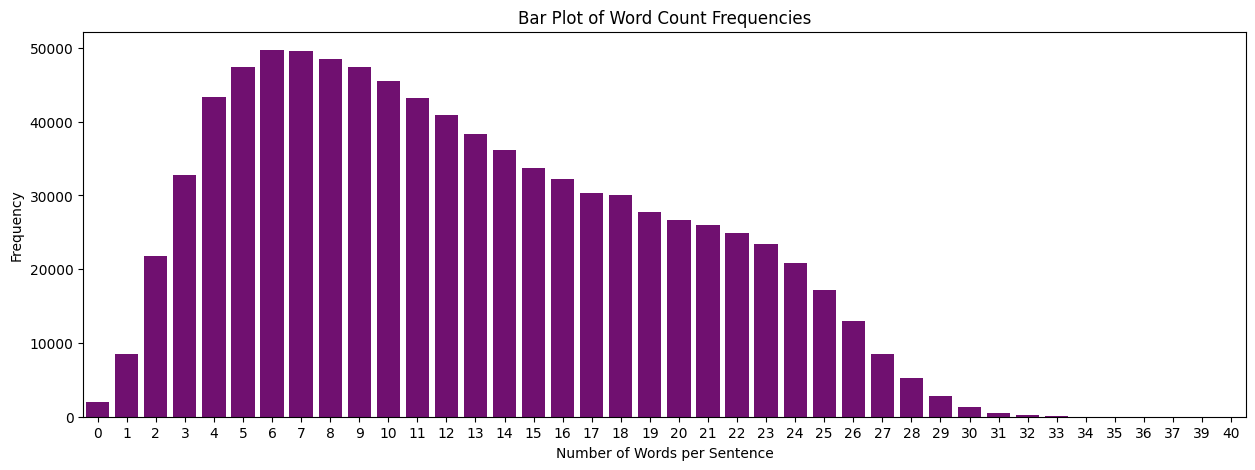

In [ ]:
df['word_count'] = df['preprocessing_sentence'].apply(lambda x: len(str(x).split()))

word_count_freq = df['word_count'].value_counts().sort_index()
plt.figure(figsize=(15, 5))
sns.barplot(x=word_count_freq.index, y=word_count_freq.values, color='purple')
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.title("Bar Plot of Word Count Frequencies")
plt.show()

In [ ]:
# Filter out sentences with fewer than 5 words
df = df[df['word_count'] >= 5].reset_index(drop=True)
df.head()

,label,sentence,preprocessing_sentence,word_count
0,1,http://twitpic.com/6hozr - This is the pic tha...,this is the pic that is on mollies phone that ...,14
1,1,repeating you. you. you. you. you.,repeating you you you you you,6
2,1,@domrout Hooray! Thank you very much! Your per...,hooray thank you very much your performance li...,12
3,1,@106andpark I wanna see Eminem and Brittany Sp...,i wanna see eminem and brittany spears im a go...,21
4,0,"so, after all that fuss #digitalbritain is jus...",so after all that fuss digitalbritain is just ...,18


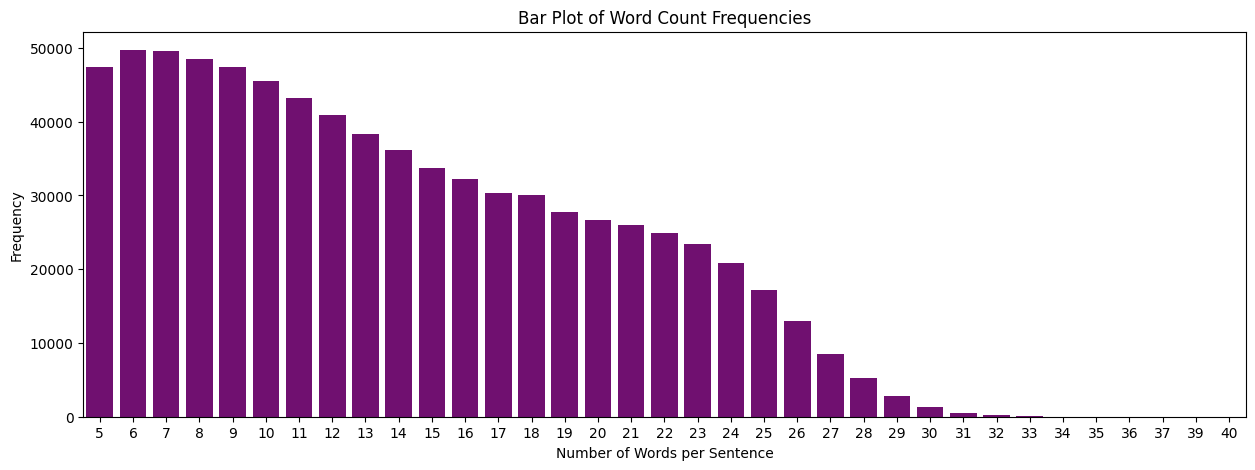

In [ ]:
df['word_count'] = df['preprocessing_sentence'].apply(lambda x: len(str(x).split()))
word_count_freq = df['word_count'].value_counts().sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(x=word_count_freq.index, y=word_count_freq.values, color='purple')
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.title("Bar Plot of Word Count Frequencies")
plt.show()

In [ ]:
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]

sample_size = 370000
df_label_0_sampled = df_label_0.sample(n=sample_size, random_state=42)
df_label_1_sampled = df_label_1.sample(n=sample_size, random_state=42)

df = pd.concat([df_label_0_sampled, df_label_1_sampled])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['label'].value_counts())

print("Number of unique values:", df['label'].nunique())
print("Unique values:", df['label'].unique())
print("Value Counts:", df['label'].value_counts() )

label
1    370000
0    370000
Name: count, dtype: int64
Number of unique values: 2
Unique values: [1 0]
Value Counts: label
1    370000
0    370000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.20)

In [ ]:
len(train), len(test)

(592000, 148000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vectorization = CountVectorizer()
tfidf_transformation = TfidfTransformer()

In [ ]:
X_train_count_vector = count_vectorization.fit_transform(train["preprocessing_sentence"])
X_train_tfidf_vector = tfidf_transformation.fit_transform(X_train_count_vector)

X_test_count_vector = count_vectorization.transform(test["preprocessing_sentence"])
X_test_tfidf_vector = tfidf_transformation.transform(X_test_count_vector)

y_train = train['label']
y_test = test['label']

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

In [ ]:
model_prediction = dict()

In [ ]:
# Logistic Regression
model = LogisticRegression(C=1).fit(X_train_tfidf_vector, y_train)
model_prediction['Logistic'] = model.predict(X_test_tfidf_vector)

In [ ]:
# Bernoulli Naive Bayes
model = BernoulliNB().fit(X_train_tfidf_vector, y_train)
model_prediction['Bernoulli'] = model.predict(X_test_tfidf_vector)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print("ACCURACY SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(accuracy_score(y_test, model_prediction[model_name])*100, 2))

ACCURACY SCORE:

Logistic :  79.19
Bernoulli :  77.51


In [ ]:
print("F1 SCORE:\n")
for model_name in model_prediction.keys():
  print(model_name, ': ', round(f1_score(y_test, model_prediction[model_name]), 2))

F1 SCORE:

Logistic :  0.79
Bernoulli :  0.77


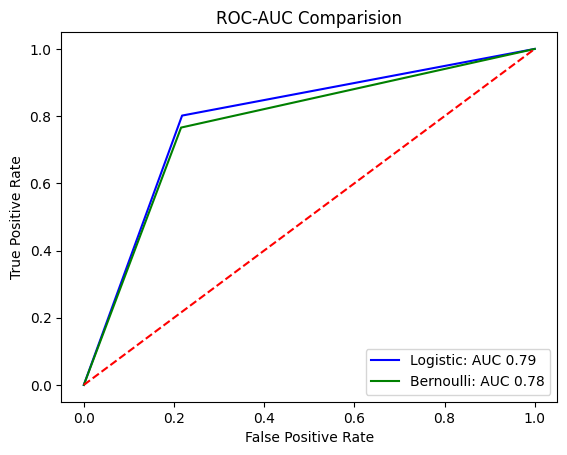

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

count = 0
colors = ['b', 'g']
for model, prediction in model_prediction.items():
    fpr, tpr, threshold = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[count], label='%s: AUC %0.2f'% (model, roc_auc))
    count += 1

plt.title('ROC-AUC Comparision')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(X_train_tfidf_vector, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameter: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.79
Best parameter:  {'C': 1}
Best estimator:  LogisticRegression(C=1)


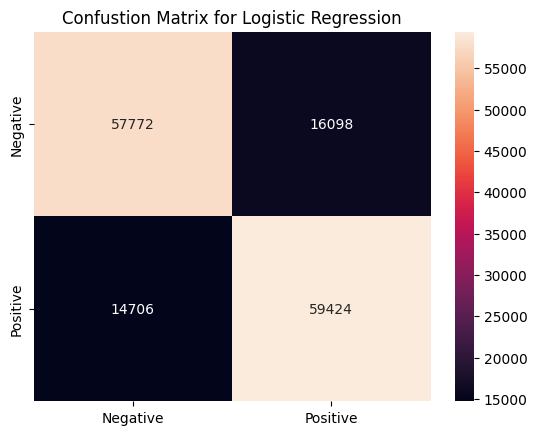

In [ ]:
# Confusion Matrix for Logistic Regression
import seaborn as sns

conf_mat = confusion_matrix(y_test, model_prediction['Logistic'])
axes = ["Negative", "Positive"]
confusion_matrix_df = pd.DataFrame(conf_mat, axes, axes, dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confustion Matrix for Logistic Regression")
plt.show()